In [1]:
import datetime
import pathlib
import time
import math

import obspy
from obspy.signal import PPSD
import scipy

#%matplotlib #Run this line if you want interactive plots
import matplotlib.pyplot as plt
import numpy as np

import hvsr.hvsr as hvsr

In [5]:
dPath = r"C:\Users\riley\OneDrive - University of Illinois - Urbana\Data_OneDrive\Seismic\HVSR\Data\RAC84\\"[:-1]
mPath = r'C:\Users\riley\LocalData\Github\hvsrpy\resources\raspshake_metadata.inv'

params = hvsr.input_param(network='AM',
                            station='RAC84',
                            loc='00', 
                            channels=['EHZ', 'EHN', 'EHE'],
                            acq_date='2023-02-13',
                            starttime = '14:40:00.00',
                            endtime = '15:00:00.00',
                            tzone = -6,#or 'local', #or 'UTC'
                            dst=False,
                            lon = -88.2290526,
                            lat =  40.1012122,
                            elevation = 755,
                            site='UOFI1',
                            depth = 0,
                            dataPath = dPath,
                            metaPath = mPath
                            )

In [3]:
params = hvsr.getShakeMetadata(params, write=False)
inStream = hvsr.fetchdata(dPath, params['inv'], date=params['acq_date'])
stream = hvsr.trimdata(inStream, start=params['starttime'], end=params['endtime'], export='mseed', exportdir=r'C:\Users\riley\LocalData\Temp', site=params['site'])
ppsds = hvsr.generatePPSDs(stream=stream, paz=params['paz'], ppsd_length=60)
hvsr_dict = hvsr.process_hvsr(ppsds, method=4, params=params)
hvsr_dict = hvsr.check_peaks(hvsrdict=hvsr_dict, rank=True, hvsr_band=[0.5, 25], peak_water_level=1.8, do_rank=False)

Day of Year: 44


c:\Users\riley\.conda\envs\seismic38\lib\site-packages\obspy\core\stream.py:3134: UserWarning: No matching response information found.
  warnings.warn(str(e))


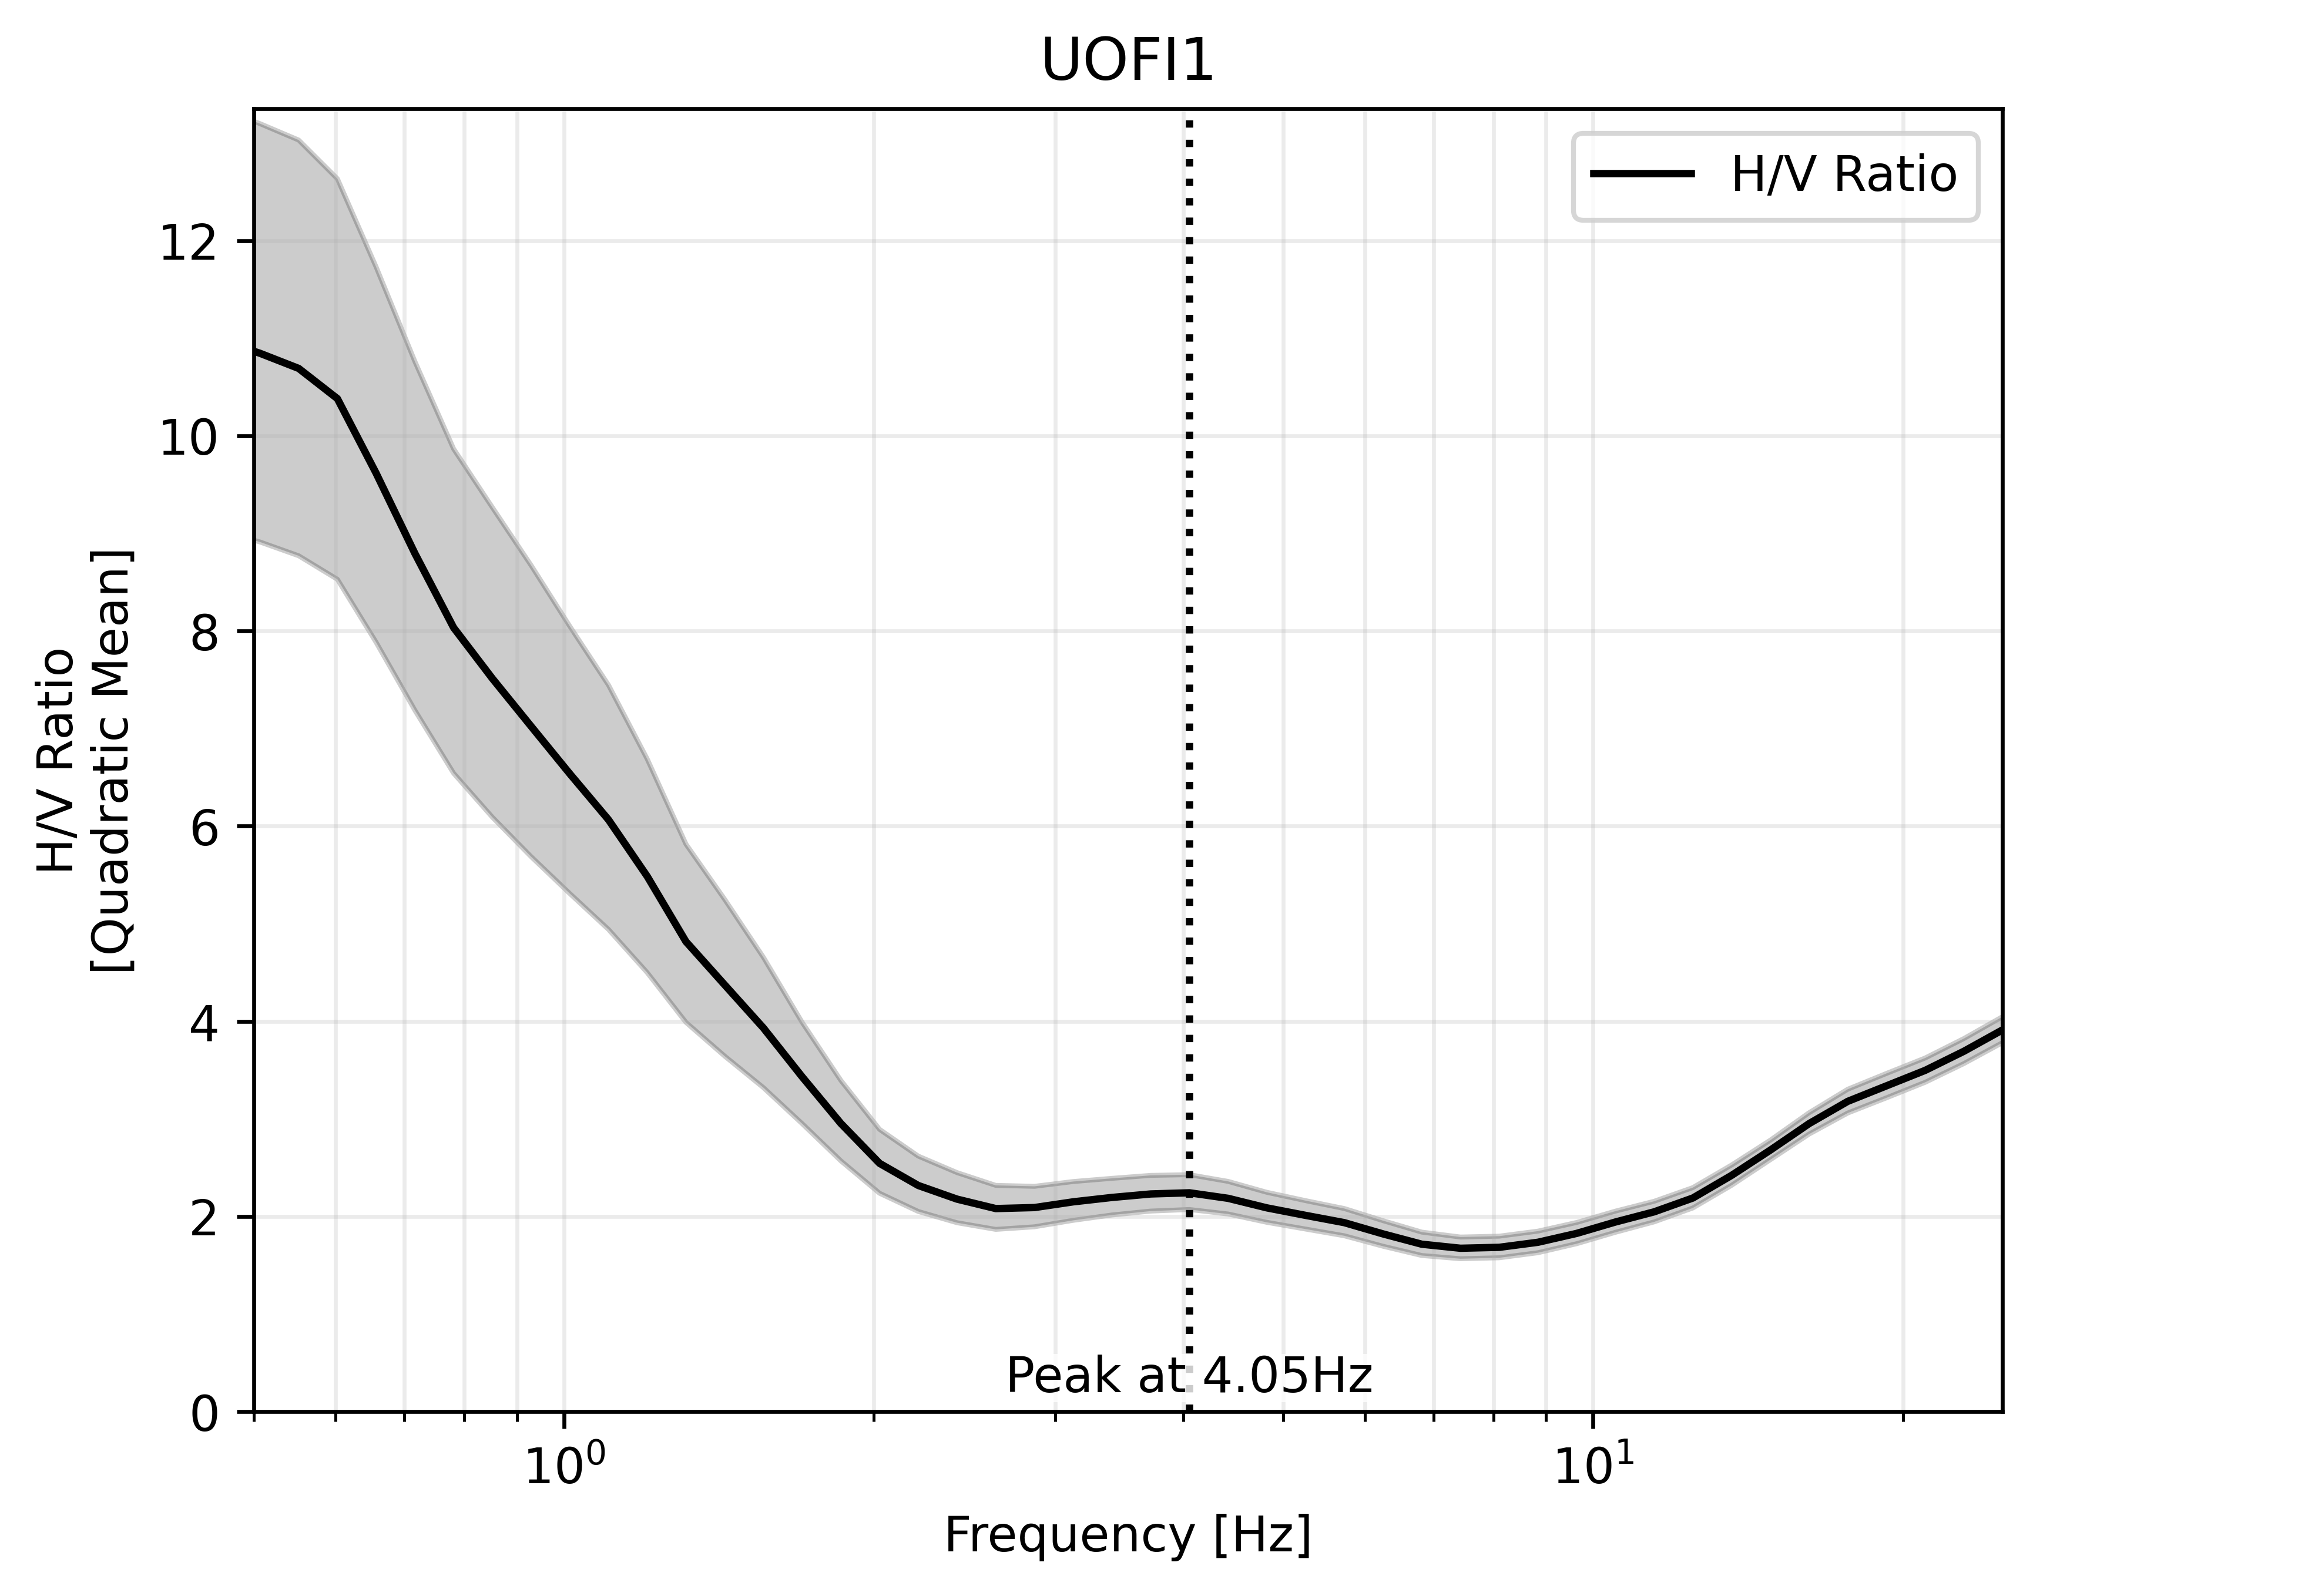

In [6]:
hvsr.hvplot(hvsr_dict, kind='HVSR p all ann', grid='both', save_dir=r'C:\Users\riley\OneDrive\Desktop', show=True)